In [64]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation

In [65]:
GAMES_CSV = "data/games.csv"
PLAYS_CSV = "data/plays.csv"
WEEK_GLOB = "data/week*.csv"

In [66]:
GAME_ID = 2018090600
PLAY_ID = 190
str_GAME_ID = str(GAME_ID) + "_" + str(PLAY_ID)
OUT_GIF = "animations/" + str_GAME_ID + "_animation.gif"

In [67]:
TEAM_COLORS = {
    "ARI": ("#97233F", "#000000"), "ATL": ("#A71930", "#000000"),
    "BAL": ("#241773", "#9E7C0C"), "BUF": ("#00338D", "#C60C30"),
    "CAR": ("#0085CA", "#101820"), "CHI": ("#0B162A", "#C83803"),
    "CIN": ("#FB4F14", "#000000"), "CLE": ("#311D00", "#FF3C00"),
    "DAL": ("#041E42", "#869397"), "DEN": ("#FB4F14", "#002244"),
    "DET": ("#0076B6", "#B0B7BC"), "GB":  ("#203731", "#FFB612"),
    "HOU": ("#03202F", "#A71930"), "IND": ("#002C5F", "#A2AAAD"),
    "JAX": ("#006778", "#9F792C"), "KC":  ("#E31837", "#FFB81C"),
    "LA": ("#0080C6", "#FFC20E"), "LAR": ("#003594", "#FFA300"),
    "LV":  ("#000000", "#A5ACAF"), "MIA": ("#008E97", "#FC4C02"),
    "MIN": ("#4F2683", "#FFC62F"), "NE":  ("#002244", "#C60C30"),
    "NO":  ("#D3BC8D", "#101820"), "NYG": ("#0B2265", "#A71930"),
    "NYJ": ("#125740", "#FFFFFF"), "PHI": ("#004C54", "#A5ACAF"),
    "PIT": ("#FFB612", "#101820"), "SEA": ("#002244", "#69BE28"),
    "SF":  ("#AA0000", "#B3995D"), "TB":  ("#D50A0A", "#FF7900"),
    "TEN": ("#0C2340", "#4B92DB"), "WAS": ("#5A1414", "#FFB612"),
}

In [68]:
games = pd.read_csv(GAMES_CSV)
plays = pd.read_csv(PLAYS_CSV)

In [69]:
game_row = games.loc[games["gameId"] == GAME_ID]
game_row = game_row.iloc[0]
actual_week = (game_row["week"])
selected_week = actual_week


In [70]:
week_file_needed = f"data/week{actual_week}.csv"
actual = pd.read_csv(week_file_needed, usecols=["gameId","playId"])
tracking = pd.read_csv(week_file_needed)

In [71]:
track = tracking[(pd.to_numeric(tracking["gameId"], errors="coerce") == GAME_ID) &
                 (pd.to_numeric(tracking["playId"], errors="coerce") == PLAY_ID)].copy()

In [72]:
required_cols = {"gameId","playId","frameId","x","y","team","s","dir"}

for c in ["gameId","playId","frameId"]:
    track[c] = pd.to_numeric(track[c], errors="coerce")

frame_ids = (track["frameId"].dropna().astype(int).sort_values().unique().tolist())
print(f"Frames found: {len(frame_ids)}  (first={frame_ids[0]}, last={frame_ids[-1]})")

Frames found: 73  (first=1, last=73)


In [73]:
home_abbr = str(game_row["homeTeamAbbr"])
away_abbr = str(game_row["visitorTeamAbbr"])
home_1, home_2 = TEAM_COLORS.get(home_abbr)
away_1, away_2 = TEAM_COLORS.get(away_abbr)

In [74]:
play_dir = str(track.iloc[0].get("playDirection", "right")).lower()
abs_yl = float(plays.loc[(plays["gameId"] == GAME_ID) & (plays["playId"] == PLAY_ID), "absoluteYardlineNumber"].iloc[0])
yards_to_go = float(plays.loc[(plays["gameId"] == GAME_ID) & (plays["playId"] == PLAY_ID), "yardsToGo"].iloc[0])

In [75]:
if play_dir == "left":
    line_of_scrimmage = abs_yl
    to_go_line = line_of_scrimmage - yards_to_go
else:
    line_of_scrimmage = 110 - abs_yl
    to_go_line = line_of_scrimmage + yards_to_go

In [76]:
desc_col = next((c for c in plays.columns if c.lower() == "playdescription"), None)
title_txt = str(plays.loc[(plays["gameId"] == GAME_ID) & (plays["playId"] == PLAY_ID), desc_col].iloc[0]) \
            if desc_col else f"Play {GAME_ID}-{PLAY_ID}"

In [77]:
need_cols = ["x","y","s","dir","event","displayName","jerseyNumber","frameId","team"]
track = track[[c for c in need_cols if c in track.columns]].copy()
rad = np.deg2rad(pd.to_numeric(track["dir"], errors="coerce"))
speed = pd.to_numeric(track["s"], errors="coerce").fillna(0.0)
track["v_x"] = np.sin(rad) * speed
track["v_y"] = np.cos(rad) * speed

In [78]:
def map_team(t):
    t = str(t)
    if t == "home": return home_abbr
    if t == "away": return away_abbr
    return t

In [79]:
track["team"] = track["team"].astype(str).apply(map_team)
home_df = track[track["team"] == home_abbr]
away_df = track[track["team"] == away_abbr]
ball_df = track[track["team"] == "football"]
FIELD_W = 120.0
FIELD_H = 160.0/3.0
ARROW_SCALE = 1.0

In [80]:
def draw_field(ax, field_color="#ffffff", line_color="#212529", number_color="#adb5bd"):
    ax.set_xlim(0, FIELD_W); ax.set_ylim(0, FIELD_H); ax.set_aspect("equal")
    ax.set_facecolor(field_color); ax.set_xticks([]); ax.set_yticks([])
    for s in ax.spines.values(): s.set_visible(False)

    ax.plot([0, FIELD_W], [0, 0], color=line_color, lw=1)
    ax.plot([0, FIELD_W], [FIELD_H, FIELD_H], color=line_color, lw=1)
    ax.plot([0, 0], [0, FIELD_H], color=line_color, lw=1)
    ax.plot([FIELD_W, FIELD_W], [0, FIELD_H], color=line_color, lw=1)
    for x in np.arange(10, 111, 5):
        ax.plot([x, x], [0, FIELD_H], color=line_color, lw=0.5)

    xs = np.arange(10, 111, 1)
    hash_y1 = (160/6 + 18.5/6)
    hash_y2 = (160/6 - 18.5/6)
    for x in xs:
        ax.plot([x, x], [0, 1], color=line_color, lw=0.5)
        ax.plot([x, x], [FIELD_H-1, FIELD_H], color=line_color, lw=0.5)
        ax.plot([x, x], [hash_y1, hash_y1+1], color=line_color, lw=0.5)
        ax.plot([x, x], [hash_y2-1, hash_y2], color=line_color, lw=0.5)

    nums = list(range(10, 60, 10)) + list(range(40, 0, -10))
    for i, x in enumerate(range(20, 101, 10)):
        ax.text(x, 12, str(nums[i]), color=number_color, ha="center", va="center", fontsize=12)
        ax.text(x, FIELD_H-12, str(nums[i]), color=number_color, ha="center", va="center",
                fontsize=12, rotation=180)

C:\Users\light\AppData\Local\Temp\ipykernel_17716\1249502132.py:70: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  ball_pt.set_data(b["x"].values[0], b["y"].values[0])
C:\Users\light\AppData\Local\Temp\ipykernel_17716\1249502132.py:70: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  ball_pt.set_data(b["x"].values[0], b["y"].values[0])
C:\Users\light\AppData\Local\Temp\ipykernel_17716\1249502132.py:70: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  ball_pt.set_data(b["x"].values[0], b["y"].values[0])


Writing frame 1/73...


C:\Users\light\AppData\Local\Temp\ipykernel_17716\1249502132.py:70: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  ball_pt.set_data(b["x"].values[0], b["y"].values[0])
C:\Users\light\AppData\Local\Temp\ipykernel_17716\1249502132.py:70: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  ball_pt.set_data(b["x"].values[0], b["y"].values[0])
C:\Users\light\AppData\Local\Temp\ipykernel_17716\1249502132.py:70: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  ball_pt.set_data(b["x"].values[0], b["y"].values[0])
C:\Users\light\AppData\Local\Temp\ipykernel_17716\1249502132.py:70: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  ball_pt.set_data(

Writing frame 10/73...


C:\Users\light\AppData\Local\Temp\ipykernel_17716\1249502132.py:70: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  ball_pt.set_data(b["x"].values[0], b["y"].values[0])
C:\Users\light\AppData\Local\Temp\ipykernel_17716\1249502132.py:70: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  ball_pt.set_data(b["x"].values[0], b["y"].values[0])
C:\Users\light\AppData\Local\Temp\ipykernel_17716\1249502132.py:70: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  ball_pt.set_data(b["x"].values[0], b["y"].values[0])
C:\Users\light\AppData\Local\Temp\ipykernel_17716\1249502132.py:70: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  ball_pt.set_data(

Writing frame 20/73...


C:\Users\light\AppData\Local\Temp\ipykernel_17716\1249502132.py:70: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  ball_pt.set_data(b["x"].values[0], b["y"].values[0])
C:\Users\light\AppData\Local\Temp\ipykernel_17716\1249502132.py:70: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  ball_pt.set_data(b["x"].values[0], b["y"].values[0])
C:\Users\light\AppData\Local\Temp\ipykernel_17716\1249502132.py:70: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  ball_pt.set_data(b["x"].values[0], b["y"].values[0])
C:\Users\light\AppData\Local\Temp\ipykernel_17716\1249502132.py:70: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  ball_pt.set_data(

Writing frame 30/73...


C:\Users\light\AppData\Local\Temp\ipykernel_17716\1249502132.py:70: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  ball_pt.set_data(b["x"].values[0], b["y"].values[0])
C:\Users\light\AppData\Local\Temp\ipykernel_17716\1249502132.py:70: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  ball_pt.set_data(b["x"].values[0], b["y"].values[0])
C:\Users\light\AppData\Local\Temp\ipykernel_17716\1249502132.py:70: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  ball_pt.set_data(b["x"].values[0], b["y"].values[0])
C:\Users\light\AppData\Local\Temp\ipykernel_17716\1249502132.py:70: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  ball_pt.set_data(

Writing frame 40/73...


C:\Users\light\AppData\Local\Temp\ipykernel_17716\1249502132.py:70: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  ball_pt.set_data(b["x"].values[0], b["y"].values[0])
C:\Users\light\AppData\Local\Temp\ipykernel_17716\1249502132.py:70: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  ball_pt.set_data(b["x"].values[0], b["y"].values[0])
C:\Users\light\AppData\Local\Temp\ipykernel_17716\1249502132.py:70: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  ball_pt.set_data(b["x"].values[0], b["y"].values[0])
C:\Users\light\AppData\Local\Temp\ipykernel_17716\1249502132.py:70: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  ball_pt.set_data(

Writing frame 50/73...


C:\Users\light\AppData\Local\Temp\ipykernel_17716\1249502132.py:70: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  ball_pt.set_data(b["x"].values[0], b["y"].values[0])
C:\Users\light\AppData\Local\Temp\ipykernel_17716\1249502132.py:70: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  ball_pt.set_data(b["x"].values[0], b["y"].values[0])
C:\Users\light\AppData\Local\Temp\ipykernel_17716\1249502132.py:70: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  ball_pt.set_data(b["x"].values[0], b["y"].values[0])
C:\Users\light\AppData\Local\Temp\ipykernel_17716\1249502132.py:70: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  ball_pt.set_data(

Writing frame 60/73...


C:\Users\light\AppData\Local\Temp\ipykernel_17716\1249502132.py:70: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  ball_pt.set_data(b["x"].values[0], b["y"].values[0])
C:\Users\light\AppData\Local\Temp\ipykernel_17716\1249502132.py:70: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  ball_pt.set_data(b["x"].values[0], b["y"].values[0])
C:\Users\light\AppData\Local\Temp\ipykernel_17716\1249502132.py:70: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  ball_pt.set_data(b["x"].values[0], b["y"].values[0])
C:\Users\light\AppData\Local\Temp\ipykernel_17716\1249502132.py:70: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  ball_pt.set_data(

Writing frame 70/73...


C:\Users\light\AppData\Local\Temp\ipykernel_17716\1249502132.py:70: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  ball_pt.set_data(b["x"].values[0], b["y"].values[0])
C:\Users\light\AppData\Local\Temp\ipykernel_17716\1249502132.py:70: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  ball_pt.set_data(b["x"].values[0], b["y"].values[0])


Writing frame 73/73...


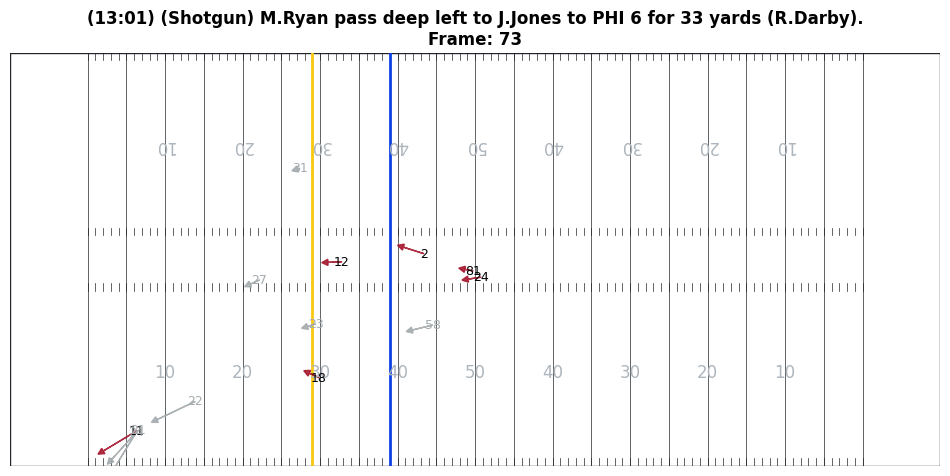

In [81]:
fig, ax = plt.subplots(figsize=(12, 6))
draw_field(ax)
ax.plot([line_of_scrimmage, line_of_scrimmage], [0, FIELD_H], color="#0d41e1", lw=2)
ax.plot([to_go_line, to_go_line], [0, FIELD_H], color="#f9c80e", lw=2)

# Persistent artists
away_pts = ax.scatter([], [], s=250, facecolors="#f8f9fa", edgecolors=away_2, linewidths=2, zorder=3)
home_pts = ax.scatter([], [], s=250, facecolors=home_1, edgecolors=home_2, linewidths=2, zorder=3)
(ball_pt,) = ax.plot([], [], "o", ms=8, mfc="#935e38", mec="#d9d9d9", mew=1.5, zorder=4)
title = ax.set_title(title_txt, fontsize=12, weight="bold")

# Dynamic artists tracked so we can safely remove them between frames
jersey_texts = []
arrow_artists = []

def init():
    away_pts.set_offsets(np.empty((0, 2)))
    home_pts.set_offsets(np.empty((0, 2)))
    ball_pt.set_data([], [])
    return [away_pts, home_pts, ball_pt, title]

def clear_dynamic():
    global arrow_artists, jersey_texts
    for a in arrow_artists:
        a.remove()
    arrow_artists = []
    for t in jersey_texts:
        t.remove()
    jersey_texts = []

def draw_team(frame_id, team_df, arrow_color, num_color):
    sub = team_df[team_df["frameId"] == frame_id]
    if sub.empty:
        return None, [], []
    pts = sub[["x","y"]].values
    arrows, texts = [], []
    for _, r in sub.iterrows():
        arr = ax.arrow(r["x"], r["y"], ARROW_SCALE*r["v_x"], ARROW_SCALE*r["v_y"],
                       head_width=0.8, head_length=0.8, length_includes_head=True,
                       fc=arrow_color, ec=arrow_color, alpha=0.9, lw=1.0, zorder=2)
        arrows.append(arr)
        num = "" if pd.isna(r.get("jerseyNumber")) else str(int(r["jerseyNumber"]))
        txt = ax.text(r["x"], r["y"], num, color=num_color, fontsize=9,
                      ha="center", va="center", zorder=5)
        texts.append(txt)
    return pts, texts, arrows

def animate(frame_id):
    clear_dynamic()

    # Away
    pts_away, txt_away, arr_away = draw_team(frame_id, away_df, away_1, away_2)
    if pts_away is not None:
        away_pts.set_offsets(pts_away)
        away_pts.set_edgecolors(away_2)

    # Home
    pts_home, txt_home, arr_home = draw_team(frame_id, home_df, home_2, home_2)
    if pts_home is not None:
        home_pts.set_offsets(pts_home)
        home_pts.set_edgecolors(home_2)

    # Track/removal for next frame
    arrow_artists.extend(arr_away + arr_home)
    jersey_texts.extend(txt_away + txt_home)

    # Ball
    b = ball_df[ball_df["frameId"] == frame_id]
    if not b.empty:
        ball_pt.set_data(b["x"].values[0], b["y"].values[0])
    else:
        ball_pt.set_data([], [])

    title.set_text(f"{title_txt}\nFrame: {frame_id}")
    return [away_pts, home_pts, ball_pt, title, *arrow_artists, *jersey_texts]

# Use actual frame IDs
assert len(frame_ids) > 0, "frame_ids is empty"
anim = animation.FuncAnimation(
    fig, animate, init_func=init,
    frames=frame_ids, interval=100, blit=False, cache_frame_data=False
)

# Show inline if Jupyter, else save GIF with progress
def _in_notebook():
    try:
        from IPython import get_ipython
        return "IPython" in globals() and get_ipython() is not None
    except Exception:
        return False

if _in_notebook():
    from IPython.display import HTML, display
    display(HTML(anim.to_jshtml()))
else:
    writer = animation.PillowWriter(fps=10, metadata=dict(artist="you"))
    def _progress(i, n):
        if i == 0 or (i+1) == n or (i+1) % 10 == 0:
            print(f"Writing frame {i+1}/{n}...")
    anim.save(OUT_GIF, writer=writer, dpi=100, progress_callback=_progress)